# Trabalho Prático 2

## Bruno Jardim (A91680) e José Ferreira(A91636)


In [3]:
!pip install z3-solver

     |████████████████████████████████| 33.0 MB 18 kB/s 



1. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 
    >  O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.
    2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

## Análise

### 1) Gerar um grafo ligado com N vértices.

1. Para garantirmos que para quaisquer dois nodos $\langle n_1,n_2 \rangle$ existe um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$, geraremos um grafo cíclico com $N$ nodos, estando logo garantido de partida que existe um caminho entre $n_1 \leadsto n_2$ e um caminho $n_2 \leadsto n_1$.


2. A partir deste grafo inicial adicionaremos arestas a cada nó assim fazendo com que cada nó tenha $n$ arestas, $n \in [1,2,3]$.

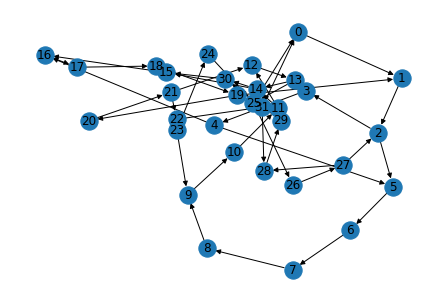

In [1]:
import networkx as nx
import numpy as np
import random


def criaGrafo(N,num):
    G = nx.cycle_graph(N,create_using = nx.DiGraph())
    current = 0
    for o in G.nodes():
        
        escolheNode = np.random.choice(G.nodes(), random.randint(0,num-1),replace = False)
        while current in escolheNode:
            escolheNode = np.random.choice(G.nodes(), random.randint(0,num-1),replace = False)
            
        #print(escolheNode)
        for d in escolheNode:
            G.add_edge(o,d)
        current +=1
    return G
G = criaGrafo(32,2)
nx.draw(G, with_labels= True)
        

### 2) Formatação do Grafo

O seguinte código formata o grafo acima representado, com o intuito de remover o número de arestas, de forma a preservar o número mínimo de arestas necessárias para salvaguardar a propriedade do grafo.

Seja $V$ o dicionário que contém o número de arestas e $X$ o conjunto de todos nodos do grafo G. A seguinte função limita o número de arestas de cada nodo.  

$$\forall x\in X: 0\leq E[x] \leq 1$$ 

O dicionário P contém o caminho da origem (o) ao destino (d) num grafo (G), usando um algoritmo existente no networkx, o shortest_simple_paths. Para simplificação da notação $C_{o,d}$ é o conjunto de todos os caminhos mais curtos existentes no grafo. 

$$\forall o,d \in X : C_{o,d} \leq 1$$

Verifica que o caminho é válido. 

```
 for o in range(N):
        for d in range(N):
            if o != d:
                for c in P[(o,d)]:
                    caminho = []
                    for k in range(len(c)-1):
                        caminho.append((c[k],c[k+1]))     
                    solver.add(Product([E[a] for a in caminho])==P[(o,d)][c])
```





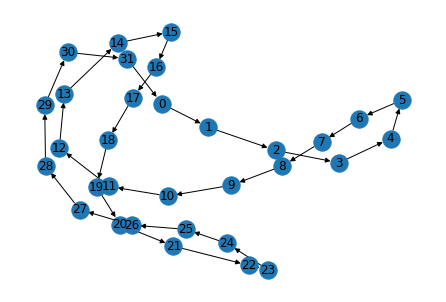

In [2]:
from z3 import *

def manutencao(G):
    N = len(G.nodes())
    solver = Optimize()
    P = {} #caminhos
    E = {} #arestas
    grafo = nx.DiGraph()
    
    #Criacao de variaveis 
    for a in G.edges():
        E[a] = Int(str(a))
        
        solver.add(0<=E[a],E[a]<=1)
        
        
    
    for o in range(N):
        for d in range(N):
            if o != d:
                P[(o,d)] = {}
                for c in nx.shortest_simple_paths(G,o,d):
                    #print(c)
                    P[(o,d)][tuple(c)] = Int(str(o)+'_'+str(d)+'_'+str(c))
    
    #Restrições
    #Para todo o par de vertices existe pelo menos um caminho
    
    for o in range(N):
        for d in range(N):
            if o != d:
                solver.add(Sum([P[(o,d)][c] for c in P[(o,d)]]) >= 1)
                #print(Sum([P[(o,d)][c] for c in P[(o,d)]]) >= 1)
    
    
    #Para cada caminho entre cada par de vertices
    for o in range(N):
        for d in range(N):
            if o != d:
                for c in P[(o,d)]:
                    caminho = []
                    for k in range(len(c)-1):
                        caminho.append((c[k],c[k+1]))
                    
                    
                    solver.add(math.prod([E[a] for a in caminho])==P[(o,d)][c])
           
           
                    
    solver.minimize(Sum([E[a] for a in G.edges()]))

    if solver.check() == sat:
        m = solver.model()
        for (a,b) in E:
            if m[E[(a,b)]] == 1:
                grafo.add_edge(a,b)
    return grafo
graph = manutencao(G)
nx.draw(graph,with_labels=True)
    